In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import keras
from keras import layers, optimizers
from keras import backend as K
from keras.models import Model
import tensorflow as tf

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

### Loading the datasets

In [7]:
files = os.listdir('data')
files = ['data/'+ i for i in files]
files.sort()

datasets = [pd.read_csv(i, sep='\t') for i in files]
names = list(datasets[0].columns[1:]) #extract gene names

### Cast into matrix form

In [5]:
# the dataset is formatted such that the first column contains x,y coordinate pairs.
# the coordinates are read and the counts cast into matrix form

train_data = []
for frame in datasets:
    x = [float(i.partition('x')[0]) for i in frame.iloc[:,0]]
    y = [float(i.partition('x')[2])for i in frame.iloc[:,0]]
    
    # since coordinates are non-integer we need to round them
    x_round = [int(i+0.5) -1 for i in x] #shift to the left, so all reps fit into 32x32 
    y_round = [int(i+0.5) for i in y]

    mats = []
    
    #loop over genes
    for i in range(1,frame.shape[1]):
        mat = np.zeros([32,32])
        #fill spatial arrays for each gene
        for x, y, val in zip(x_round, y_round, frame.iloc[:,i]):
            mat[y,x] = val
        #scaling the data on each gene from 0 to 1
        mat = mat/(mat.max())
        mats.append(mat)
    mats = np.array(mats)
    train_data.append(mats)

train_data = np.array(train_data)

In [6]:
np.save('train_data.npy', train_data)
train_data = np.load('train_data.npy', allow_pickle=True)

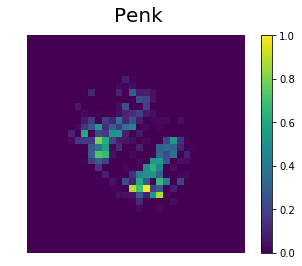

In [11]:
#plot sample gene counts
gene_id = names.index('Penk')
fig, ax = plt.subplots()
sc = ax.matshow(train_data[0][gene_id])
fig.colorbar(sc)
fig.suptitle(names[gene_id], fontsize=20)
plt.axis('off')
plt.show()

### Define VAE archirecture

In [12]:
img_shape = (32, 32, 1)
latent_dim = 20
beta = 1

input_img = keras.Input(shape=img_shape) 

x = layers.Conv2D(16, 4, padding='same', activation='relu', strides=(2,2))(input_img)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 4, padding='same', activation='relu', strides=(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 4, padding='same', activation='relu', strides=(2,2))(x)
x = layers.BatchNormalization()(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x) 

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon
z = layers.Lambda(sampling)([z_mean, z_log_var])

decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x) 
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 4, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 4, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(16, 4, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(1, 4, padding='same', activation='sigmoid')(x)
decoder = Model(decoder_input, x)
encoder = Model(input_img, z)
z_decoded = decoder(z) 

def vae_loss(input_img, z_decoded):
    input_img = K.flatten(input_img)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(input_img, z_decoded) 
    kl_loss = -0.5e-4 * beta * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

adam = optimizers.Adam(lr=5e-4)
vae = Model(input_img, z_decoded)
vae.compile(optimizer=adam, loss=vae_loss)

### Train or load weights

In [13]:
X = np.expand_dims(train_data[0], axis = 3) #choose replicate and fix dimension to feed into VAE
trained = 1
if not trained:
    vae.fit(X,X,
        shuffle=True,
        batch_size=64,
        epochs=10,
        verbose=2
        )
    vae.save_weights('vae_rep1_new.hdf5')
else: vae.load_weights('vae_rep1.hdf5')

### Plotting overlay with histological image

In [14]:
file = open('alignments/Rep1_MOB_transformation.txt','r')
for line in file:
    split = line.split(' ')
align = [float(i) for i in split]

x = [float(i.partition('x')[0]) for i in datasets[0].iloc[:,0]]
y = [float(i.partition('x')[2])for i in datasets[0].iloc[:,0]]

#alignments are used to scale and shift the coordinates to match the histological picture
x_up = [i*align[0]+align[6] for i in x]
y_up = [i*align[4]+align[7] for i in y]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2731: DecompressionBombWarning: Image size (92080232 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


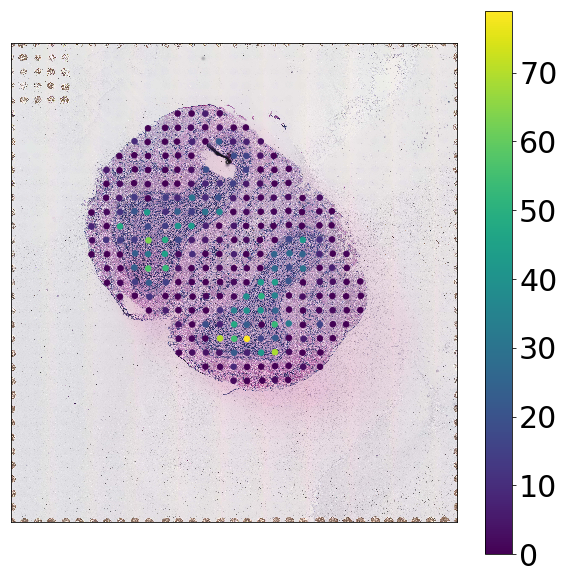

In [15]:
img = plt.imread('images/HE_Rep1.jpg')
plt.rcParams["figure.figsize"] = (10,10)

#for the scatter plot we need gene counts in the form of original list
spots = datasets[0].loc[:,'Penk']

fig, ax = plt.subplots()
sc = ax.scatter(x_up, y_up, c = spots, s = 30)
plt.setp(ax, xticks=[], yticks=[])
ax.imshow(img)
cbar=fig.colorbar(sc)
cbar.ax.tick_params(labelsize=30)

### Correlations and p-values

In [16]:
from scipy import stats
#calculate correlations  in latent space for these 3 genes 
genes = ['Penk', 'Doc2g', 'Kctd12']

latent = encoder.predict(X)
latent_t = np.transpose(latent)
latent_df = pd.DataFrame(latent_t, columns = names)

correlations = []
for gene in genes:
    corr = [stats.pearsonr(latent_df.loc[:,gene], latent_df.loc[:,i]) for i in names]
    corr = pd.DataFrame(corr, names)
    corr.columns = ['correlations', 'p-values']
    correlations.append(corr)

correlations[0].nlargest(5,'correlations')

,correlations,p-values
Penk,1.000000,0.000000e+00
Kcnh3,0.936230,1.312343e-09
Nrgn,0.898491,7.480157e-08
Epha4,0.897386,8.211601e-08
Tenm3,0.891146,1.364548e-07


### Use correlation matrix to form concept vectors of Penk-, Doc2g- and Kctd12-like genes

In [31]:
top_correlation = [i.nlargest(50, 'correlations') for i in correlations]

#extract corresponding indexes of the most highly correlated genes
idxs = []
for corr in top_correlation:
    idx = [names.index(i) for i in corr.index]
    idxs.append(idx)

#obtain latent vectors and average
latent_top_corr = [encoder.predict(X[[i]]) for i in idxs]

#note that for this dataset we define the concept vectors simplfy as the average, 
#not as the difference of averages as in the celebA case
concept_vectors = [np.average(i, axis = 0) for i in latent_top_corr] 
decoded = [decoder.predict(np.expand_dims(i, axis=0))[0,:,:,0] for i in concept_vectors]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


### Create saliency maps with respect to these concept vectors

In [38]:
import tensorflow as tf
sess = K.get_session()
from deepexplain.tensorflow import DeepExplain
from deepexplain.utils import preprocess

k = 95

with DeepExplain(session=sess, graph=sess.graph) as de:
    
    method = 'rectgrad'
    
    input_layer = tf.placeholder(tf.float32, [50,32,32,1] )
    
    #saliency maps are  created for genes with top 50 correlation statistics wrt Penk, Doc2g, Kctd12,
    #method de.explain feeds imgs into input_layer
    imgs = [X[[i]] for i in idxs]
    
    #obtain latent representations
    lats = encoder(input_layer)

    #calculate dot product
    class_neurons = [K.sum(lats*i) for i in concept_vectors]

    #call method to obtain saliency maps
    attribution = [de.explain(method, neuron, input_layer, img, percentile=k) for neuron, img in zip(class_neurons, imgs)]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


### Plotting saliency maps

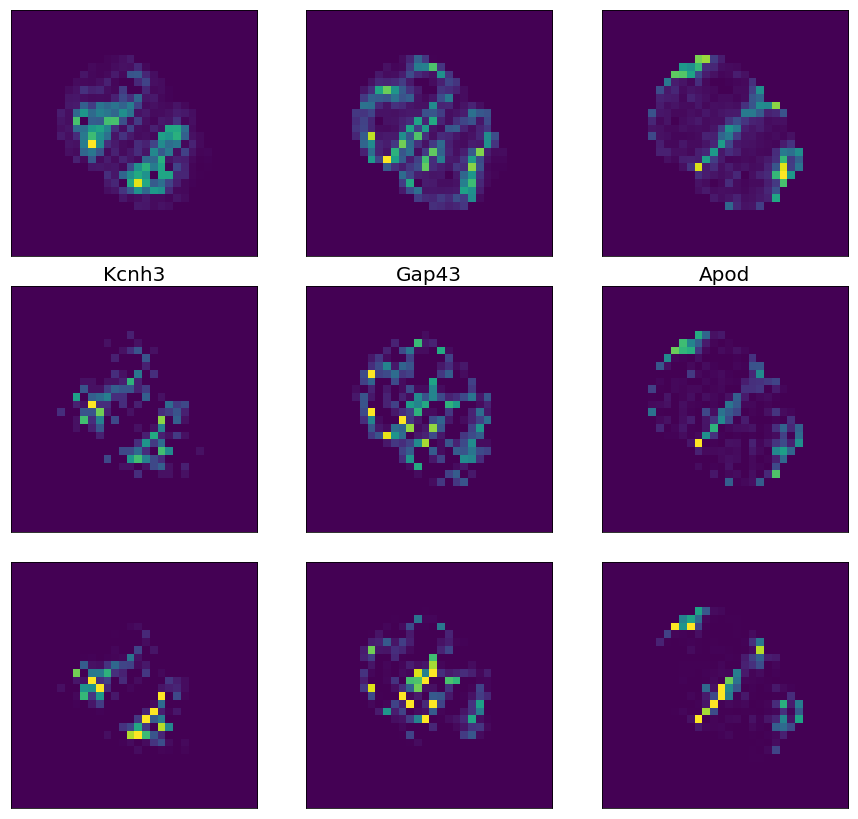

In [39]:
#plot genes with highest correlation statistic

f, axs = plt.subplots(3,3, figsize=(15,15))


axs[0,0].matshow(decoded[0])
axs[0,1].matshow(decoded[1])
axs[0,2].matshow(decoded[2])

gene1 = 1
gene2 = 1
gene3 = 1

axs[1,0].set_title(top_correlation[0].index[gene1], fontsize=20)
axs[1,0].imshow(imgs[0][gene1,:,:,0])
axs[2,0].imshow(preprocess(attribution[0],0.5,99.5)[gene1])

axs[1,1].set_title(top_correlation[1].index[gene2], fontsize=20)
axs[1,1].imshow(imgs[1][gene2,:,:,0])
axs[2,1].imshow(preprocess(attribution[1],0.5,99.5)[gene2])

axs[1,2].set_title(top_correlation[2].index[gene3], fontsize=20)
axs[1,2].imshow(imgs[2][gene3,:,:,0])
axs[2,2].imshow(preprocess(attribution[2],0.5,99.5)[gene3])


plt.setp(axs, xticks=[], yticks=[])

plt.subplots_adjust(hspace=0.05, wspace=0.2)
plt.savefig("heatmaps_top.png")